# Particle Filter Demo

This notebook demos a particle filter with prediction and adaptive parameter estimation on an aircraft tracking example.

In [1]:
%matplotlib notebook
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy.matlib

## Data Generating Process

The aircraft has deterministic initial state vector $\mathbf{y}_{0} = \left(0, 0, 9000, -100, 115, 0\right)$, where the first three components are position and the next three are velocity. The state evolves via the stochastic difference equation:
$$\mathbf{y}_{k + 1} = \begin{bmatrix} 1 & 0 & 0 & \Delta & 0 & 0 \\
0 & 1 & 0 & 0 & \Delta & 0 \\
0 & 0 & 1 & 0 & 0 & \Delta \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}\mathbf{y}_{k} + \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ -12*\mathbb{I}_{y_{k, 3} > 2000} \end{bmatrix} + \mathcal{W}_{k}$$
where $\Delta$ is the sample time of $6$ seconds, $\mathbb{I}$ is the indicator function and $\mathcal{W}_{k}$ is an i.i.d. sequence of noise from the distribution:
$$ \mathcal{W}_{k} \sim \mathcal{N}\left(\begin{bmatrix} 2 \\ 2 \\ 0 \\ -0.1 \\ 0.1 \\ 0.01 \end{bmatrix}, \begin{bmatrix} 2 & 0 & 0 & 0 & 0 & 0 \\
0 & 2 & 0 & 0 & 0 & 0 \\
0 & 0 & 2 & 0 & 0 & 0 \\
0 & 0 & 0 & 0.01 & 0 & 0 \\
0 & 0 & 0 & 0 & 0.01 & 0\\
0 & 0 & 0 & 0 & 0 & 0.01
\end{bmatrix}^{2} \right)$$
the state measurement $\mathbf{z}_{k}$ is corrupted by noise so that
$$ \mathbf{z}_{k} = y_{k} + \mathcal{V}_{k}$$
where
$$ \mathcal{W}_{k} \sim \mathcal{N}\left(\begin{bmatrix} 2 \\ 2 \\ 0 \\ -0.1 \\ 0.1 \\ 0.01 \end{bmatrix}, \begin{bmatrix} 10 & 0 & 0 & 0 & 0 & 0 \\
0 & 10 & 0 & 0 & 0 & 0 \\
0 & 0 & 2 & 0 & 0 & 0 \\
0 & 0 & 0 & 0.1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0.1 & 0\\
0 & 0 & 0 & 0 & 0 & 0.01
\end{bmatrix}^{2} \right)$$

In [2]:
dt = 6 #timestep
A = np.array([[1, 0, 0, dt, 0, 0], \
              [0, 1, 0, 0, dt, 0], \
              [0, 0, 1, 0, 0, dt], \
              [0, 0, 0, 1, 0, 0], \
              [0, 0, 0, 0, 1, 0], \
              [0, 0, 0, 0, 0, 1]]) #state update matrix

y0 = np.array([0, 0, 9000, -100, 115, 0])  #initial state

kmax = 120 #number of timesteps to estimate
y = np.zeros((6, kmax + 1))
y[:, 0] = y0

#generate the data
for k in range(kmax):
    noise = np.matmul(np.diag([2, 2, 2, 0.01, 0.01, 0.01]), np.random.normal(size = (6, 1))) \
    + np.array([2, 2, 0, -0.1, 0.1, 0.01]).reshape(6, 1)
    if (y[2, k] > 2000):
        y[:, k + 1] = (np.matmul(np.vstack((A[0:5, :], np.zeros((1, 6)))), y[:, k]).reshape(6, 1) \
        + np.array([0, 0, 0, 0, 0, -12]).reshape(6, 1) + noise).reshape(1, 6)
    else:
        y[:, k + 1] = (np.matmul(np.vstack((A[0:5, :], np.zeros((1, 6)))), y[:, k]).reshape(6, 1) \
        + noise).reshape(1, 6)


## Particle Filter

The particle filter is augmented with an additional state to adaptively estimate the descent rate of the aircraft; denote this augmented state by $\tilde{\mathbf{x}}_{k}$. The particle filter is calibrated with the initial distribution:
$$ p\left(\tilde{\mathbf{x}}_{0}\right) = \mathcal{N}\left(\begin{bmatrix} 0 \\ 0 \\ 9000 \\ -100 \\ 115 \\ 0 \\ 10.5 \end{bmatrix}, \begin{bmatrix} 250 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 250 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 250 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 10 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 10 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1.2
\end{bmatrix}^{2} \right)$$
the transition distribution:
$$ p\left(\tilde{\mathbf{x}}_{k + 1}\middle|\tilde{\mathbf{x}}_{k}\right) = \mathcal{N}\left(\begin{bmatrix} 1 & 0 & 0 & \Delta & 0 & 0 & 0\\
0 & 1 & 0 & 0 & \Delta & 0 & 0\\
0 & 0 & 1 & 0 & 0 & \Delta & 0\\
0 & 0 & 0 & 1 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}\tilde{\mathbf{x}}_{k} + \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ -\tilde{x}_{k, 7}\operatorname{sign}\left(\tilde{x}_{k, 3} - 2000\right)\mathbb{I}_{\left|\tilde{x}_{k, 3} - 2000\right| > 50} \\ 0\end{bmatrix}, \begin{bmatrix} 2 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 2 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 2 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0.01 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0.01 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0.02
\end{bmatrix}^{2} \right)$$
and the measurement distribution:
$$ p\left(\mathbf{z}_{k}\middle|\tilde{\mathbf{x}}_{k}\right) \propto \left[\left(\tilde{\mathbf{x}}_{k, 1:6} - \mathbf{z}_{k}\right)^{\top}\begin{bmatrix} 0.5 & 0 & 0 & 0 & 0 & 0 \\
0 & 0.5 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0.1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0.1 & 0\\
0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}^{2}\left(\tilde{\mathbf{x}}_{k, 1:6} - \mathbf{z}_{k}\right)\right]^{-1} $$
At the beginning, we sample $N$ particles from the initial distribution. Then a single iteration of the algorithm follows:
 1. Sample $N$ particles from the transition distribution using the previous particles.
 2. For each particle evaluate the likelihood/weights using the measurement distribution. 
 3. Normalise the weights so they sum to one.
 4. Resample the particles with replacement according to the weights (ie. each particle is resampled with probability proportional to its weight).
 
### Predict-ahead

To predict the trajectory $H$ steps in the future by the distribution $p\left(\tilde{\mathbf{x}}_{k:\left(k + H\right)}\middle|\mathbf{z}_{1:k}\right)$, we can factorise
$$p\left(\tilde{\mathbf{x}}_{k:\left(k + H\right)}\middle|\mathbf{z}_{1:k}\right) = p\left(\tilde{\mathbf{x}}_{k + H}\middle|\tilde{\mathbf{x}}_{k + H - 1}\right)\dots p\left(\tilde{\mathbf{x}}_{k + 1}\middle|\tilde{\mathbf{x}}_{k}\right)p\left(\tilde{\mathbf{x}}_{k}\middle|\mathbf{z}_{k}\right) $$
as the state transition is a Markov process and $\tilde{\mathbf{x}}_{k + 1}$ and $\mathbf{z}_{k}$ are conditionally independent given $\tilde{\mathbf{x}}_{k}$. To implement an approximation of this in the particle filter, we can propagate the particles $H$ steps ahead through the transition distribution.

In [3]:
N = 1000 #number of particles
#generate initial particles
x = np.matlib.repmat(y0.reshape(6, 1), 1, N) + \
np.matmul(np.diag([250, 250, 250, 10, 10, 1]), np.random.normal(size = (6, N)))
#initial guess of descent rate
x = np.vstack((x, 10.5 + 1.2*np.random.normal(size = (1, N))))

<IPython.core.display.Javascript object>


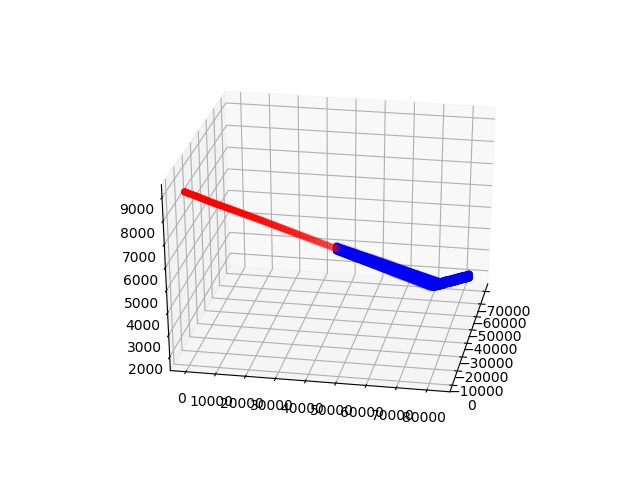

In [4]:
#store state point estimates
x_est = np.zeros((7, kmax - 1))

#perform filtering
for kk in range(kmax - 1):
    
    #propagate particles
    for i in range(N):
        if (x[2, i] > 2050):
            x[0:6, i] = (np.matmul(np.vstack((A[0:5, :], np.zeros((1, 6)))), x[0:6, i]).reshape(6, 1) \
            + np.array([0, 0, 0, 0, 0, -x[6, i]]).reshape(6, 1)).reshape(1, 6)    
        elif (x[2, i] < 1950):
            x[0:6, i] = (np.matmul(np.vstack((A[0:5, :], np.zeros((1, 6)))), x[0:6, i]).reshape(6, 1) \
            + np.array([0, 0, 0, 0, 0, x[6, i]]).reshape(6, 1)).reshape(1, 6)                
        else:
            x[0:6, i] = np.matmul(np.vstack((A[0:5, :], np.zeros((1, 6)))), x[0:6, i])
    
    noise = np.matmul(np.diag([2, 2, 2, 0.01, 0.01, 1, 0.02]), np.random.normal(size = (7, N)))
    x += noise
    
    #generate noisy measurement
    noise = np.matmul(np.diag([10, 10, 2, 0.1, 0.1, 0.01]), np.random.normal(size = (6, 1)))
    z = y[:, kk + 1].reshape(6, 1) + noise
    
    #likelihood function is reciprocal of squared weighted norm
    w = x[0:6, :] - np.matlib.repmat(z, 1, N)
    w = np.matmul(np.diag([0.5, 0.5, 1, 0.1, 0.1, 1]), w)
    w = np.square(w)
    w = np.sum(w, axis = 0)
    w = 1/w
    #normalise weights
    w = w/np.sum(w)
    
    #bootstrap resampling
    I = np.digitize(np.random.uniform(size=N), np.cumsum(w))
    x = x[:, I]
    
    #point estimate using mean of particles
    x_est[:, kk] = np.mean(x, axis=1)
    
    if (kk == 60):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x_est[0, 0:(kk + 1)], x_est[1, 0:(kk + 1)], x_est[2, 0:(kk + 1)], c='r')
        ax.scatter(x[0, :], x[1, :], x[2, :], c='b', alpha=0.05)
        plt.show()
    
    xp = np.copy(x)
    #perform prediction
    for k in range(kk + 1, kmax - 1):
        #propagate particles
        for i in range(N):
            if (xp[2, i] > 2050):
                xp[0:6, i] = (np.matmul(np.vstack((A[0:5, :], np.zeros((1, 6)))), xp[0:6, i]).reshape(6, 1) \
                + np.array([0, 0, 0, 0, 0, -xp[6, i]]).reshape(6, 1)).reshape(1, 6)    
            elif (xp[2, i] < 1950):
                xp[0:6, i] = (np.matmul(np.vstack((A[0:5, :], np.zeros((1, 6)))), xp[0:6, i]).reshape(6, 1) \
                + np.array([0, 0, 0, 0, 0, xp[6, i]]).reshape(6, 1)).reshape(1, 6)                
            else:
                xp[0:6, i] = np.matmul(np.vstack((A[0:5, :], np.zeros((1, 6)))), xp[0:6, i])
    
        noise = np.matmul(np.diag([2, 2, 2, 0.01, 0.01, 1, 0.02]), np.random.normal(size = (7, N)))
        xp += noise
        if (kk == 60):
            ax.scatter(xp[0, :], xp[1, :], xp[2, :], c='b', alpha=0.05)